# CW2: Natural Language Processing: Classification of News Articles


In [1]:
# import neccesary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import (
    TextVectorization,
    Embedding,
    LSTM,
    Bidirectional,
    Dense,
    Embedding,
)
import tensorflow.keras
from tensorflow.keras.models import Sequential
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier

# 1. Data preparation
Import dataset. 

In [2]:
# Importing the dataset. As done in lab 4, you usually have a look at the data. Here we simply show the first 5 rows
train_data = pd.read_csv("news_dataset/train.csv")
test_data = pd.read_csv("news_dataset/test.csv")
train_data.head(5)

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


In [3]:
# Here shows what the news looks like
print(train_data["Description"][0])

Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.


In [4]:
# Show the end of the dataset
train_data.tail(10)

,Class Index,Title,Description
119990,1,Barack Obama Gets #36;1.9 Million Book Deal (AP),"AP - U.S. Sen.-elect Barack Obama, whose 1995 ..."
119991,2,Rauffer Beats Favorites to Win Downhill,"VAL GARDENA, Italy (Reuters) - Max Rauffer be..."
119992,1,Iraqis Face Winter Shivering by Candlelight,BAGHDAD (Reuters) - As if the daily struggle ...
119993,1,AU Says Sudan Begins Troop Withdrawal from Darfur,ABUJA (Reuters) - The African Union said on S...
119994,1,Syria Redeploys Some Security Forces in Lebanon,"BEIRUT (Reuters) - Syria, under intense press..."
119995,1,Pakistan's Musharraf Says Won't Quit as Army C...,KARACHI (Reuters) - Pakistani President Perve...
119996,2,Renteria signing a top-shelf deal,Red Sox general manager Theo Epstein acknowled...
119997,2,Saban not going to Dolphins yet,The Miami Dolphins will put their courtship of...
119998,2,Today's NFL games,PITTSBURGH at NY GIANTS Time: 1:30 p.m. Line: ...
119999,2,Nets get Carter from Raptors,INDIANAPOLIS -- All-Star Vince Carter was trad...


In [5]:
print(train_data.shape)  # To check the number of rows and columns
train_data.info()  # To understand data types and non-null counts
train_data.describe()  # To get statistical information about numerical columns

(120000, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Class Index  120000 non-null  int64 
 1   Title        120000 non-null  object
 2   Description  120000 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.7+ MB


,Class Index
count,120000.000000
mean,2.500000
std,1.118039
min,1.000000
25%,1.750000
50%,2.500000
75%,3.250000
max,4.000000


Change labels from 1-4 to 0-3

In [6]:
# substract 1 from the target variable for both, train and test data
train_data["Class Index"] = train_data["Class Index"] - 1
test_data["Class Index"] = test_data["Class Index"] - 1
label_names = ["World", "Sports", "Business", "Sci/Tech"] # 0 is "World", 1 is "Sports", ...

In [7]:
# Check if t has been corrected
train_data.head(5)

,Class Index,Title,Description
0,2,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,2,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,2,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,2,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,2,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


## Preprocessing 

Lowercase descriptions and clean up non-letter characters.

**TODO 1**: Remove the occurences of "http" "href", "https" and "www". Also, remove the names of the news agencies (Reuters, AP, ...) from the datasets.

In [8]:
# Function to preprocess the data
def preprocess_text(string):
    # Remove http, https, href, and www
    string = re.sub(r"\b(?:http|https|href|www)\S*\b", "", string)

    # Remove news agencies names
    news_agencies = ["Reuters", "AFP", "AP"]  # nList of news agencies
    for agency in news_agencies:
        string = re.sub(r'\b' + agency + r'\b', '', string, flags=re.IGNORECASE)

    string = string.lower()
    string = string.replace("'", " ")
    string = string.replace("\\", " ")
    string = re.sub(r"[^a-zA-Z]", " ", string)
    return string

# Apply the preprocessing function to the 'Description' column in both train and test datasets
train_data["Description"] = train_data["Description"].apply(preprocess_text)
test_data["Description"] = test_data["Description"].apply(preprocess_text)


train_data.head(5)

,Class Index,Title,Description
0,2,Wall St. Bears Claw Back Into the Black (Reuters),short sellers wall street s dwindling band...
1,2,Carlyle Looks Toward Commercial Aerospace (Reu...,private investment firm carlyle group whic...
2,2,Oil and Economy Cloud Stocks' Outlook (Reuters),soaring crude prices plus worries about the...
3,2,Iraq Halts Oil Exports from Main Southern Pipe...,authorities have halted oil export flows fr...
4,2,"Oil prices soar to all-time record, posing new...",tearaway world oil prices toppling records...


Convert dataframes to lists (needed for further functions).

In [9]:
# Convert dataframes to list
train_data_list = train_data["Description"].tolist()
test_data_list = test_data["Description"].tolist()
train_labels_list = train_data["Class Index"].tolist()
test_labels_list = test_data["Class Index"].tolist()

Create validation set (taking out 20% of test set)

In [10]:
(train_data_list, validation_data_list,
 train_labels_list, validation_labels_list) = train_test_split(train_data_list, train_labels_list, test_size=0.2, stratify=train_labels_list)

### Removing Stop Words
Remove stopwords from the *stopword* corpus.

In [11]:
# Download the stopwords
nltk.download("stopwords")

# Create the function to remove stopwords
def remove_stopwords(data_list):
    stopword_list = stopwords.words("english")
    for i in range(len(data_list)):
        data_list[i] = " ".join(
            [word for word in data_list[i].split() if word not in (stopword_list)]
        )
    return data_list

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\a\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
train_data_list = remove_stopwords(train_data_list)
validation_data_list = remove_stopwords(validation_data_list)
test_data_list = remove_stopwords(test_data_list)

### TODO 2: STEMMING
Use **Stemming** or **Lemmatization** to grammatical word variations.

In [13]:
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import wordnet
import nltk
nltk.download('wordnet')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
# Initialize stemmer
stemmer = PorterStemmer()

# Function for stemming
def perform_stemming(text):
    stemmed_text = " ".join([stemmer.stem(word) for word in text.split()])
    return stemmed_text

# Apply stemming to the data
stemmed_train_data_list = [perform_stemming(text) for text in train_data_list]
stemmed_validation_data_list = [perform_stemming(text) for text in validation_data_list]
stemmed_test_data_list = [perform_stemming(text) for text in test_data_list]

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\a\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 2. Recurrent Neural Network classifier with Keras and Tensorflow

One-hot encode the labels (0 -> 0001, 1 -> 0010, ...) to match NN classifier head output.

In [14]:
# the labels are of value 0, 1, 2, 3. We need to convert them to one-hot encoded vectors 
train_labels = tensorflow.keras.utils.to_categorical(np.array(train_labels_list), num_classes=4)
validation_labels = tensorflow.keras.utils.to_categorical(np.array(validation_labels_list), num_classes=4)
test_labels = tensorflow.keras.utils.to_categorical(np.array(test_labels_list), num_classes=4)
print(train_labels.shape)

(96000, 4)


First we use the TextVectorization layer to convert the text to a sequence of integers. You can read about how this works  [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization).


In [15]:
# this will create a vocabulary of the top 2500 words and then convert the text to a sequence of numbers
vocab_size = 2500 # how many of the most frequent words to keep
sequence_length = 30 # how many words we use to represent a description
vectorizer = TextVectorization(max_tokens=vocab_size, output_sequence_length=sequence_length)
# fit the vectorizer on the training data (find the most common words and assign values to them)
vectorizer.adapt(stemmed_train_data_list)
# show the selected words
print(vectorizer.get_vocabulary())

['', '[UNK]', 'said', 'new', 'year', 'quot', 'compani', 'two', 'us', 'first', 'lt', 'gt', 'world', 'one', 'monday', 'wednesday', 'tuesday', 'thursday', 'inc', 'friday', 'game', 'week', 'report', 'state', 'u', 'last', 'yesterday', 'york', 'say', 'time', 'presid', 'unit', 'million', 'three', 'nation', 'day', 'price', 'corp', 'stock', 'oil', 'govern', 'plan', 'sunday', 'offici', 'secur', 'would', 'month', 'group', 'servic', 'today', 'peopl', 'announc', 'second', 'open', 'team', 'market', 'could', 'win', 'end', 'season', 'iraq', 'saturday', 'kill', 'percent', 'softwar', 'night', 'next', 'back', 'third', 'use', 'expect', 'busi', 'minist', 'quarter', 'microsoft', 'comput', 'make', 'countri', 'share', 'lead', 'high', 'intern', 'run', 'record', 'internet', 'take', 'network', 'four', 'billion', 'technolog', 'final', 'american', 'help', 'system', 'washington', 'top', 'may', 'elect', 'sale', 'research', 'citi', 'news', 'former', 'leader', 'home', 'releas', 'victori', 'target', 'start', 'feder', '

In [16]:
# vectorize the training data (replace words by their associated values)
train_data_vectorized = vectorizer(stemmed_train_data_list)
# vectorize the validation data
validation_data_vectorized = vectorizer(stemmed_validation_data_list)
# vectorize the test data
test_data_vectorized = vectorizer(stemmed_test_data_list)
# this shape shows that we have our 96000 training examples, each as a vector of 30 integers
print(train_data_vectorized.shape)

(96000, 30)


In [17]:
# see how a vectorized news description looks like
print(train_data_vectorized[1])

tf.Tensor(
[ 289  980  353 1196  939   32 2234  899  177  564   31  289  647 1222
   56  715  241    0    0    0    0    0    0    0    0    0    0    0
    0    0], shape=(30,), dtype=int64)


We then build a RNN.

We use an *Embedding layer* to convert the integer sequences to embeddings. You can read about how this works [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding).

The Bidirectional layer takes the input and passes it forwards and backwards through the LSTM (Long-Short Term Memory) layer. It allows the network to learn the context of the sentence in both directions, so information from both previous and following words is taken into account.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          80000     
                                                                 
 bidirectional (Bidirection  (None, 64)                16640     
 al)                                                             
                                                                 
 dense (Dense)               (None, 4)                 260       
                                                                 
Total params: 96900 (378.52 KB)
Trainable params: 96900 (378.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5
750/750 [==============================] - 12s 13ms/step - loss: 0.4569 - accuracy: 0.8381 - val_loss: 0.3326 - val_accuracy: 0.8864
Epoch 2/5
750/750 [==============================] - 10s 13ms/step - loss

<Axes: >

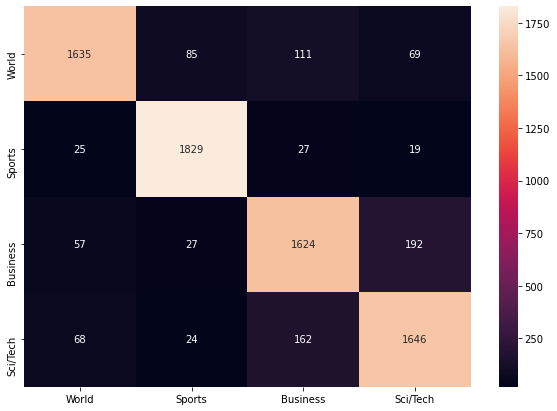

In [18]:
model = Sequential()
model.add(Embedding(vocab_size, 32))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(4, activation="softmax"))

model.summary()

# compile the model
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# fit the model
model.fit(
    train_data_vectorized,
    train_labels,
    epochs=5,
    batch_size=128,
    verbose=1,
    validation_data=(validation_data_vectorized, validation_labels),
)

# predict the labels on the test data
rnn_predictions = model.predict(test_data_vectorized)
# since predictions are one-hot encoded, we convert them to an int label taking the output with higher value
rnn_predictions = np.argmax(rnn_predictions, axis=1)

# calculate the accuracy score
accuracy = accuracy_score(test_labels_list, rnn_predictions)
print("Test Set Accuracy: ", accuracy)
# create a confusion matrix
cm = confusion_matrix(test_labels_list, rnn_predictions)
# plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=label_names, yticklabels=label_names)

In [19]:
print(f"Test set accuracy for RNN model: {accuracy_score(test_labels_list, rnn_predictions)*100:.2f}%")

Test set accuracy for RNN model: 88.61%


# TODO 3: Creating Example Predictions
Test the model. Create some fresh sample news (copy them from a news site like BBC) then see if the model can predict the correct labels. Use one example per class.

Also, find one example that gets misclassified and briefly discuss here why it might happen:

In [20]:
sample_news = list()
# TODO 3: create some fresh sample news (copy them from a news site like BBC) then see if the model can predict the correct labels
# Use one example per class
sample_news.append("Ukraine and Russia have exchanged hundreds of prisoners of war, in what is being described by officials in Kyiv as the biggest swap of the war.")
sample_news.append("Rory McIlroy says he would be open to play in a tournament backed by LIV Golf if the controversial tour became more like cricket's Indian Premier League.")
sample_news.append("Bosses of the biggest firms will earn more than the typical worker by Thursday lunchtime, research claims.")
sample_news.append("The company which became well known for its idea of shooting people hundreds of miles an hour through a vacuum has shut down.")
# Also, find one example that gets misclassified and discuss why it might happen in the markdown above.
sample_news.append("SpaceX has been accused of unlawfully firing eight workers who were critical of its multi-billionaire chief executive Elon Musk.")

# preprocess the sample news
sample_news = [preprocess_text(i) for i in sample_news]
sample_news = remove_stopwords(sample_news)

# If you added stemming/lemmatization, do it on sample_news as well
stemmed_sample_news = [perform_stemming(text) for text in sample_news]

# vectorize the sample news
sample_news_vectorized = vectorizer(stemmed_sample_news)

# predict using the neural network
prediction = model.predict(sample_news_vectorized)
prediction = np.argmax(prediction, axis=1)
for i in prediction:
     print("NN classifier prediction: ", label_names[prediction[i]], "News")


1/1 [==============================] - 0s 18ms/step
NN classifier prediction:  World News
NN classifier prediction:  Sports News
NN classifier prediction:  Business News
NN classifier prediction:  Sci/Tech News
NN classifier prediction:  Business News


Sport's News - https://www.bbc.com/sport/golf/67870607

Tech News- https://www.bbc.com/news/technology-67801235

Misclassified News- https://www.bbc.com/news/business-67878940

World News- https://www.bbc.com/news/world-europe-67872417

Business News- https://www.bbc.com/news/business-67877235


The missclassified news is misclassified because it is both considered Business news and comes from the tech sphere. The misrepresentation as Sci/Tech news may occur if the emphasis is exclusively on SpaceX's technological innovations or advancements in space exploration, ignoring the article's core theme of labor disputes and legal concerns. While there is mention of SpaceX's engagement in space-related activities, the main narrative is around internal business concerns, therefore "Business" is a more appropriate category.

## TODO 4: Create a new model
Try to improve the RNN model, of implement a CNN (with 1D convolution layers), that beats the baseline RNN

In [21]:
# TODO 4: YOUR CODE HERE
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout

# Define the CNN model
cnn_model = Sequential()

# Add an Embedding layer
cnn_model.add(Embedding(vocab_size, 128, input_length=sequence_length))

# Add Convolutional layers
cnn_model.add(Conv1D(128, 5, activation='relu'))
cnn_model.add(MaxPooling1D(5))
cnn_model.add(Conv1D(128, 5, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())

# Add Dropout for regularization
cnn_model.add(Dropout(0.5))

# Add a Dense layer for classification
cnn_model.add(Dense(64, activation='relu'))
cnn_model.add(Dense(4, activation='softmax'))  # 4 classes 

# Compile the model
cnn_model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

# Display model summary
cnn_model.summary()

# Train the CNN model
cnn_model.fit(train_data_vectorized, train_labels,
              epochs=5,
              batch_size=128,
              validation_data=(validation_data_vectorized, validation_labels))

# Evaluate the CNN model on the test set
cnn_scores = cnn_model.evaluate(test_data_vectorized, test_labels, verbose=0)
print(f"Test set accuracy for CNN model: {cnn_scores[1]*100:.2f}%")


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 30, 128)           320000    
                                                                 
 conv1d (Conv1D)             (None, 26, 128)           82048     
                                                                 
 max_pooling1d (MaxPooling1  (None, 5, 128)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 1, 128)            82048     
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dropout (Dropout)           (None, 128)              

In [22]:
# Test the Model
prediction2 = cnn_model.predict(sample_news_vectorized)
prediction2 = np.argmax(prediction2, axis=1)
for i in prediction2:
     print("CNN classifier prediction: ", label_names[prediction2[i]], "News")

1/1 [==============================] - 0s 66ms/step
CNN classifier prediction:  World News
CNN classifier prediction:  Sports News
CNN classifier prediction:  Business News
CNN classifier prediction:  Sci/Tech News
CNN classifier prediction:  Business News


In [23]:
from tensorflow.keras.layers import LSTM, Dropout

# Define an Improved RNN model
improved_rnn_model = Sequential()

# Add an Embedding layer
improved_rnn_model.add(Embedding(vocab_size, 128, input_length=sequence_length))

# Add LSTM layers with increased complexity
improved_rnn_model.add(LSTM(128, return_sequences=True))
improved_rnn_model.add(Dropout(0.3))
improved_rnn_model.add(LSTM(64))
improved_rnn_model.add(Dropout(0.3))

# Add Dense layers for classification
improved_rnn_model.add(Dense(64, activation='relu'))
improved_rnn_model.add(Dense(4, activation='softmax'))  # 4 classes 

# Compile the improved RNN model
improved_rnn_model.compile(loss='categorical_crossentropy',
                           optimizer='adam',
                           metrics=['accuracy'])

# Train the improved RNN model
improved_rnn_model.fit(train_data_vectorized, train_labels,
                       epochs=5,
                       batch_size=128,
                       validation_data=(validation_data_vectorized, validation_labels))

# Evaluate the improved RNN model on the test set
improved_rnn_scores = improved_rnn_model.evaluate(test_data_vectorized, test_labels, verbose=0)
print(f"Test set accuracy for Improved RNN model: {improved_rnn_scores[1]*100:.2f}%")


Epoch 1/5
750/750 [==============================] - 48s 61ms/step - loss: 0.4503 - accuracy: 0.8360 - val_loss: 0.3460 - val_accuracy: 0.8831
Epoch 2/5
750/750 [==============================] - 46s 61ms/step - loss: 0.3348 - accuracy: 0.8897 - val_loss: 0.3362 - val_accuracy: 0.8853
Epoch 3/5
750/750 [==============================] - 47s 63ms/step - loss: 0.3173 - accuracy: 0.8944 - val_loss: 0.3274 - val_accuracy: 0.8862
Epoch 4/5
750/750 [==============================] - 50s 67ms/step - loss: 0.2980 - accuracy: 0.8994 - val_loss: 0.3236 - val_accuracy: 0.8867
Epoch 5/5
750/750 [==============================] - 50s 67ms/step - loss: 0.2815 - accuracy: 0.9038 - val_loss: 0.3297 - val_accuracy: 0.8844
Test set accuracy for Improved RNN model: 88.22%


In [24]:
# Predict using model
prediction1 = improved_rnn_model.predict(sample_news_vectorized)
prediction1 = np.argmax(prediction1, axis=1)
for i in prediction1:
     print("Improved RNN classifier prediction: ", label_names[prediction1[i]], "News")

1/1 [==============================] - 1s 564ms/step
Improved RNN classifier prediction:  World News
Improved RNN classifier prediction:  Sports News
Improved RNN classifier prediction:  Business News
Improved RNN classifier prediction:  Sci/Tech News
Improved RNN classifier prediction:  World News


In [25]:
# Define an Improved CNN model
improved_cnn_model = Sequential()

# Add an Embedding layer
improved_cnn_model.add(Embedding(vocab_size, 128, input_length=sequence_length))

# Add Convolutional layers with increased complexity
improved_cnn_model.add(Conv1D(128, 5, activation='relu'))
improved_cnn_model.add(MaxPooling1D(5))
improved_cnn_model.add(Conv1D(128, 5, activation='relu'))
improved_cnn_model.add(GlobalMaxPooling1D())
improved_cnn_model.add(Dropout(0.5))

# Add Dense layers for classification
improved_cnn_model.add(Dense(64, activation='relu'))
improved_cnn_model.add(Dense(4, activation='softmax'))  # 4 classes 

# Compile the improved CNN model
improved_cnn_model.compile(loss='categorical_crossentropy',
                           optimizer='adam',
                           metrics=['accuracy'])

# Train the improved CNN model
improved_cnn_model.fit(train_data_vectorized, train_labels,
                       epochs=5,
                       batch_size=128,
                       validation_data=(validation_data_vectorized, validation_labels))

# Evaluate the improved CNN model on the test set
improved_cnn_scores = improved_cnn_model.evaluate(test_data_vectorized, test_labels, verbose=0)
print(f"Test set accuracy for Improved CNN model: {improved_cnn_scores[1]*100:.2f}%")


Epoch 1/5
750/750 [==============================] - 13s 16ms/step - loss: 0.4693 - accuracy: 0.8296 - val_loss: 0.3336 - val_accuracy: 0.8856
Epoch 2/5
750/750 [==============================] - 12s 16ms/step - loss: 0.3139 - accuracy: 0.8945 - val_loss: 0.3229 - val_accuracy: 0.8874
Epoch 3/5
750/750 [==============================] - 12s 16ms/step - loss: 0.2635 - accuracy: 0.9105 - val_loss: 0.3214 - val_accuracy: 0.8901
Epoch 4/5
750/750 [==============================] - 12s 16ms/step - loss: 0.2048 - accuracy: 0.9291 - val_loss: 0.3557 - val_accuracy: 0.8840
Epoch 5/5
750/750 [==============================] - 12s 16ms/step - loss: 0.1494 - accuracy: 0.9472 - val_loss: 0.4006 - val_accuracy: 0.8825
Test set accuracy for Improved CNN model: 87.39%


In [26]:
# Predict using model
prediction3 = improved_cnn_model.predict(sample_news_vectorized)
prediction3 = np.argmax(prediction3, axis=1)
for i in prediction3:
     print("Improved CNN classifier prediction: ", label_names[prediction3[i]], "News")

1/1 [==============================] - 0s 64ms/step
Improved CNN classifier prediction:  World News
Improved CNN classifier prediction:  Sports News
Improved CNN classifier prediction:  Business News
Improved CNN classifier prediction:  Sci/Tech News
Improved CNN classifier prediction:  Business News


In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout

# Create a new model using CNN architecture
cnn_model = Sequential()
cnn_model.add(Embedding(vocab_size, 128, input_length=sequence_length))
cnn_model.add(Conv1D(64, 5, activation='relu'))
cnn_model.add(MaxPooling1D(pool_size=4))
cnn_model.add(Conv1D(128, 5, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(64, activation='relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(4, activation='softmax'))

# Display the model summary
cnn_model.summary()

# Compile the model
cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit the model
cnn_model.fit(
    train_data_vectorized,
    train_labels,
    epochs=5,
    batch_size=128,
    verbose=1,
    validation_data=(validation_data_vectorized, validation_labels)
)

# Predict the labels on the test data
cnn_predictions = cnn_model.predict(test_data_vectorized)
cnn_predictions = np.argmax(cnn_predictions, axis=1)

# Calculate the accuracy score
accuracy_cnn = accuracy_score(test_labels_list, cnn_predictions)
print("Test Set Accuracy (CNN Model): {:.2f}%".format(accuracy_cnn * 100))


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 30, 128)           320000    
                                                                 
 conv1d_4 (Conv1D)           (None, 26, 64)            41024     
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 6, 64)             0         
 g1D)                                                            
                                                                 
 conv1d_5 (Conv1D)           (None, 2, 128)            41088     
                                                                 
 global_max_pooling1d_2 (Gl  (None, 128)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_7 (Dense)             (None, 64)               

In [28]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout, SpatialDropout1D

# Create a modified CNN model
cnn_model = Sequential()
cnn_model.add(Embedding(vocab_size, 128, input_length=sequence_length))
cnn_model.add(Conv1D(128, 5, activation='relu'))
cnn_model.add(MaxPooling1D(pool_size=4))
cnn_model.add(Conv1D(64, 5, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(64, activation='relu'))
cnn_model.add(Dropout(0.5))  # Adding dropout for regularization
cnn_model.add(Dense(4, activation='softmax'))

# Compile the model with a lower learning rate
optimizer = Adam(learning_rate=0.0005)  # Adjust the learning rate
cnn_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Fit the modified model
cnn_model.fit(
    train_data_vectorized,
    train_labels,
    epochs=5,
    batch_size=128,
    verbose=1,
    validation_data=(validation_data_vectorized, validation_labels)
)

# Evaluate the modified CNN model
cnn_predictions = cnn_model.predict(test_data_vectorized)
cnn_predictions = np.argmax(cnn_predictions, axis=1)
accuracy_cnn_modified = accuracy_score(test_labels_list, cnn_predictions)
print("Test Set Accuracy (Modified CNN Model): {:.2f}%".format(accuracy_cnn_modified * 100))


Epoch 1/5
750/750 [==============================] - 13s 16ms/step - loss: 0.5326 - accuracy: 0.8031 - val_loss: 0.3424 - val_accuracy: 0.8827
Epoch 2/5
750/750 [==============================] - 12s 16ms/step - loss: 0.3350 - accuracy: 0.8915 - val_loss: 0.3250 - val_accuracy: 0.8885
Epoch 3/5
750/750 [==============================] - 12s 16ms/step - loss: 0.3014 - accuracy: 0.9028 - val_loss: 0.3245 - val_accuracy: 0.8870
Epoch 4/5
750/750 [==============================] - 12s 16ms/step - loss: 0.2589 - accuracy: 0.9146 - val_loss: 0.3296 - val_accuracy: 0.8859
Epoch 5/5
238/238 [==============================] - 1s 2ms/step
Test Set Accuracy (Modified CNN Model): 88.17%


In [29]:
# Remodified the Model by increasing the Ephocs from 5 to 10

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout, SpatialDropout1D

# Create a modified CNN model
cnn_model = Sequential()
cnn_model.add(Embedding(vocab_size, 128, input_length=sequence_length))
cnn_model.add(Conv1D(128, 5, activation='relu'))
cnn_model.add(MaxPooling1D(pool_size=4))
cnn_model.add(Conv1D(64, 5, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(64, activation='relu'))
cnn_model.add(Dropout(0.5))  # Adding dropout for regularization
cnn_model.add(Dense(4, activation='softmax'))

# Compile the model with a lower learning rate
optimizer = Adam(learning_rate=0.0005)  # Adjust the learning rate
cnn_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Fit the modified model
cnn_model.fit(
    train_data_vectorized,
    train_labels,
    epochs=10,
    batch_size=128,
    verbose=1,
    validation_data=(validation_data_vectorized, validation_labels)
)

# Evaluate the modified CNN model
cnn_predictions = cnn_model.predict(test_data_vectorized)
cnn_predictions = np.argmax(cnn_predictions, axis=1)
accuracy_cnn_modified = accuracy_score(test_labels_list, cnn_predictions)
print("Test Set Accuracy (Modified CNN Model): {:.2f}%".format(accuracy_cnn_modified * 100))


Epoch 1/10
750/750 [==============================] - 13s 17ms/step - loss: 0.5473 - accuracy: 0.7949 - val_loss: 0.3429 - val_accuracy: 0.8845
Epoch 2/10
750/750 [==============================] - 12s 16ms/step - loss: 0.3351 - accuracy: 0.8911 - val_loss: 0.3296 - val_accuracy: 0.8871
Epoch 3/10
750/750 [==============================] - 12s 16ms/step - loss: 0.2986 - accuracy: 0.9025 - val_loss: 0.3236 - val_accuracy: 0.8901
Epoch 4/10
750/750 [==============================] - 12s 16ms/step - loss: 0.2565 - accuracy: 0.9162 - val_loss: 0.3295 - val_accuracy: 0.8876
Epoch 5/10
750/750 [==============================] - 12s 16ms/step - loss: 0.2012 - accuracy: 0.9351 - val_loss: 0.3619 - val_accuracy: 0.8827
Epoch 6/10
750/750 [==============================] - 12s 16ms/step - loss: 0.1410 - accuracy: 0.9555 - val_loss: 0.4149 - val_accuracy: 0.8817
Epoch 7/10
750/750 [==============================] - 12s 16ms/step - loss: 0.0961 - accuracy: 0.9693 - val_loss: 0.4695 - val_accuracy:

Following extensive work to enhance the baseline model, **the baseline model achieved the highest accuracy of 88.61% and accurately forecasted the sample news.**

## TODO  5

**TODO 1** 

Removing URLs and Links from text. This step is important since URLs often do not provide useful information for text categorization and can introduce noise into the dataset.

Removing News Agency Names. The method also removes individual news agency names such as "Reuters" and "AFP". This step is intended to reduce bias or overfitting caused by the presence of agency names in the text. It is critical when training the model on data when the agency name may be an influential component in categorization but is irrelevant in other circumstances.

**TODO 2**

Before deciding between lemminization and stemming, I decided to experiment with both approaches and assess their impact on the performance of my classification model. Both stemming and lemmatization aim to reduce words to their base or root form but use different approaches and have distinct characteristics, so I decided to experiment with both approaches and assess their impact on the performance of my classification model. Following that, I obtained the following result from the comparison:

Stemmed Validation Accuracy: 0.8960416666666666667

Accuracy of Lemmatized Validation: 0.8703333333333333

Stemming outperformed lemmatization in terms of performance, thus I chose stemming.

**TODO 3**

It is critical to evaluate the model to ensure its dependability, generalizability, and efficacy in making accurate predictions on fresh, unseen data. We will be able to ensure the reliability of our model for real-world case scenarios if we use current news to evaluate it.

**TODO 4**

In practice, it is critical to experiment with various designs, closely monitor performance metrics (accuracy, etc), and confirm the model's performance on distinct test sets. This iterative method aids in understanding how architectural changes affect the model's behavior and performance on unknown data, allowing the best model architecture for the particular task to be chosen.


## Sources:

- Implement a recurrent neural network : https://peterroelants.github.io/posts/rnn-implementation-part01/

- Peforming Encoding: https://www.geeksforgeeks.org/feature-encoding-techniques-machine-learning/

- Using Regular Expression: https://www.geeksforgeeks.org/regular-expression-python-examples/

- Performing Stemming: https://www.geeksforgeeks.org/introduction-to-stemming/

- Source for Sample News: https://www.bbc.com/

- Implementing Text Vectorization: https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization

- Implementing CNN: https://www.geeksforgeeks.org/introduction-convolution-neural-network/?ref=header_search